In [1]:
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt

In [101]:
class MyProphet():
    def __init__(self,
                 n_changepoints=25,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8,
                 seasonality_prior_scale=10.0,
                 mcmc_samples=0,
                ):
        self.n_changepoints = n_changepoints
        self.changepoints_prior_scale = changepoints_prior_scale
        self.changepoint_range = changepoint_range
        self.seasonality_prior_scale = seasonality_prior_scale
        self.mcmc_samples = mcmc_samples
        
        self.model = None
        self.trend_params = None
        self.yearly_seasonality_params = None
        self.weekly_seasonality_params = None
        self.map_approx = None
        self.trace = None
        self.posterior = None
        
        self.data = None
        self.y_min = None
        self.y_max = None
        self.ds_min = None
        self.ds_max = None

    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        
    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self._scale_data()

    def _add_trend(self):
        t = np.array(self.data["t"])
        s = np.linspace(0, self.changepoint_range * np.max(t), self.n_changepoints + 1)[1:]
    
        # * 1 casts the boolean to integers
        A = (t[:, None] > s) * 1
    
        with self.model:
            # initial growth
            k = pm.Normal("k", 0 , 5)

            changepoints_prior_scale = self.changepoints_prior_scale
            if self.changepoints_prior_scale is None:
                changepoints_prior_scale = pm.Exponential("tau", 1.5)
        
            # rate of change
            delta = pm.Laplace("delta", 0, changepoints_prior_scale, shape=self.n_changepoints)
            # offset
            m = pm.Normal("m", 0, 5)
            gamma = -s * delta
            trend = pm.Deterministic("trend", (k + pyt.tensor.dot(A, delta)) * t + (m + pyt.tensor.dot(A, gamma)))

        return trend, A, s

    def _fourier_series(self, data, p=365.25, n=10):
        x = 2 * np.pi * np.arange(1, n + 1) / p
        x = x * np.array(data["t"])[:, None]
        x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
        return x

    def _get_seasonality_n_x(self, data, period):
        if period == "yearly":
            n = 10
            p = 365.25
        else:  # weekly
            n = 3
            p = 7

        # rescale the period, as t is also scaled
        p /= (self.ds_max - self.ds_min).days
            
        return n, self._fourier_series(data, p, n)

    def _add_seasonality(self, period):
        n, x = self._get_seasonality_n_x(self.data, period)
    
        with self.model:
            beta = pm.Normal(f"beta_{period}", mu=0, sigma=self.seasonality_prior_scale, shape=2 * n)
            
        return x, beta

    def fit(self, data):
        self.data = data.copy()
        self._process_data()

        self.model = pm.Model()
        with self.model:
            trend, A, s = self._add_trend()
            x_yearly, beta_yearly = self._add_seasonality("yearly")
            x_weekly, beta_weekly = self._add_seasonality("weekly")
            trend += pyt.tensor.dot(x_yearly, beta_yearly) + pyt.tensor.dot(x_weekly, beta_weekly)
            # sigma = pm.HalfCauchy("sigma", 0.5, initval=1)
            sigma = pm.HalfNormal("sigma", 0.5, initval=1)
            obs = pm.Normal("obs", mu=trend, sigma=sigma, observed=self.data["y"])
            
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP()
            else:
                self.trace = pm.sample(self.mcmc_samples, return_inferencedata=True)
                self.posterior = pm.sample_posterior_predictive(trace=self.trace)

        self.trend_params = (trend, A, s)
        self.yearly_seasonality_params = (x_yearly, beta_yearly)
        self.weekly_seasonality_params = (x_weekly, beta_weekly)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _plot_predictions(self, future, trend_forecast, yearly_posterior, weekly_posterior, y_true=None):
        date = future['ds'].dt.to_pydatetime()
        plt.figure(figsize=(16, 3*6))
        b = 411
        plt.subplot(b)
        plt.title("Predictions")
        plt.plot(date, trend_forecast + yearly_posterior + weekly_posterior, lw=0.5)
        plt.scatter(date[:len(self.data)], self.data["y"] * self.y_max, s=0.5, color="black")

        if y_true is not None:
            plt.scatter(date[len(self.data):], y_true, s=0.5, color="green")
    
    def _predict_map(self, days, y_true=None, plot=False):
        trend, A, s = self.trend_params
        history_points = self.data.shape[0]
        probability_changepoint = self.n_changepoints / history_points
        
        future = pd.DataFrame({
            "ds": pd.DatetimeIndex(pd.concat((self.data["ds"], 
            pd.date_range(self.ds_max, self.ds_max + pd.Timedelta(days, "D"), inclusive="right").to_series()
        )))
                              })
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        
        _, x_yearly = self._get_seasonality_n_x(future, "yearly")
        _, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        yearly_posterior = self._det_seasonality_posterior(self.map_approx["beta_yearly"], x_yearly) * self.y_max
        weekly_posterior = self._det_seasonality_posterior(self.map_approx["beta_weekly"], x_weekly) * self.y_max
        
        trend_forecast = []
        future_t = np.array(future["t"])
        
        new_changepoints = future["t"][future["t"] > 1].values
        sample = np.random.random(new_changepoints.shape)
        new_changepoints = new_changepoints[sample <= probability_changepoint]
        new_s = np.r_[s, new_changepoints]
        tau = self.map_approx["tau"] if self.changepoints_prior_scale is None else self.changepoints_prior_scale
        new_delta = np.r_[self.map_approx["delta"], stats.laplace(0, tau).rvs(new_changepoints.shape[0])]
        new_A = (future_t[:, None] > new_s) * 1
        
        trend_forecast = np.array((
            (self.map_approx["k"] + np.dot(new_A, new_delta)) * future["t"] + 
            (self.map_approx["m"] + np.dot(new_A, (-new_s * new_delta)))
        ) * self.y_max)

        if plot:
            self._plot_predictions(future, trend_forecast, yearly_posterior, weekly_posterior, y_true)
            
        return trend_forecast + yearly_posterior + weekly_posterior, future

In [102]:
df = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv")
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


Output()

/tmp/ipykernel_892/401770522.py:121: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future['ds'].dt.to_pydatetime()


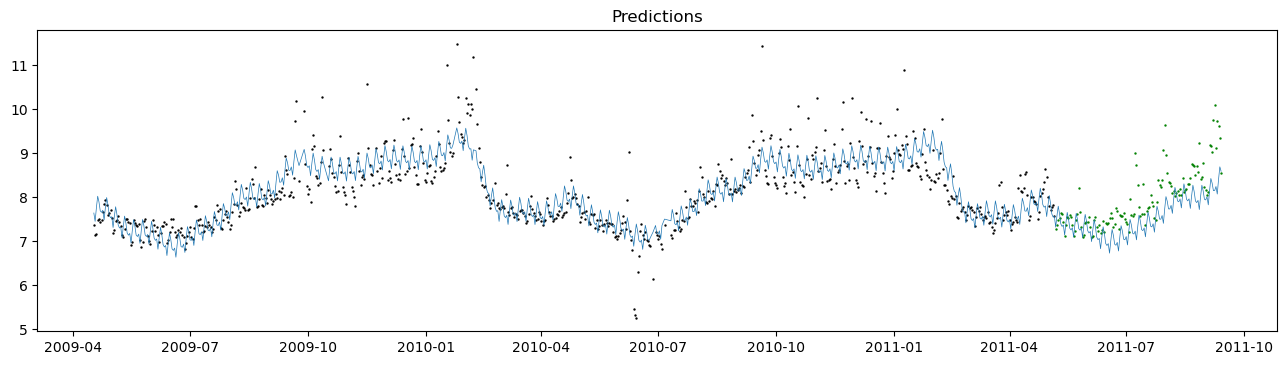

In [103]:
from random import randint

window = 730
horizon = 130
start = randint(0, len(df) - window - horizon - 1)

model = MyProphet()
# model = MyProphet()
model.fit(df[start:start + window])
preds, future = model._predict_map(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

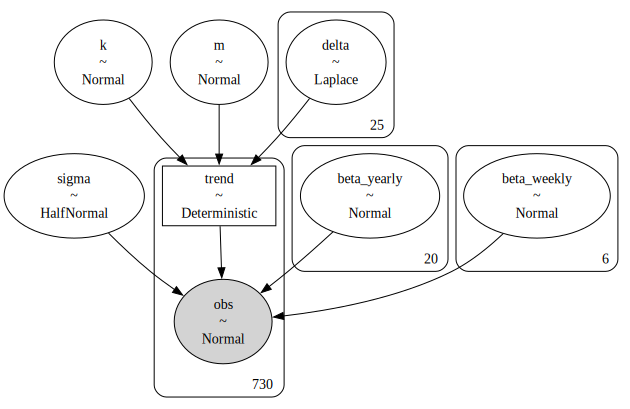

In [104]:
pm.model_to_graphviz(model.model)

Output()

/tmp/ipykernel_892/401770522.py:121: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future['ds'].dt.to_pydatetime()


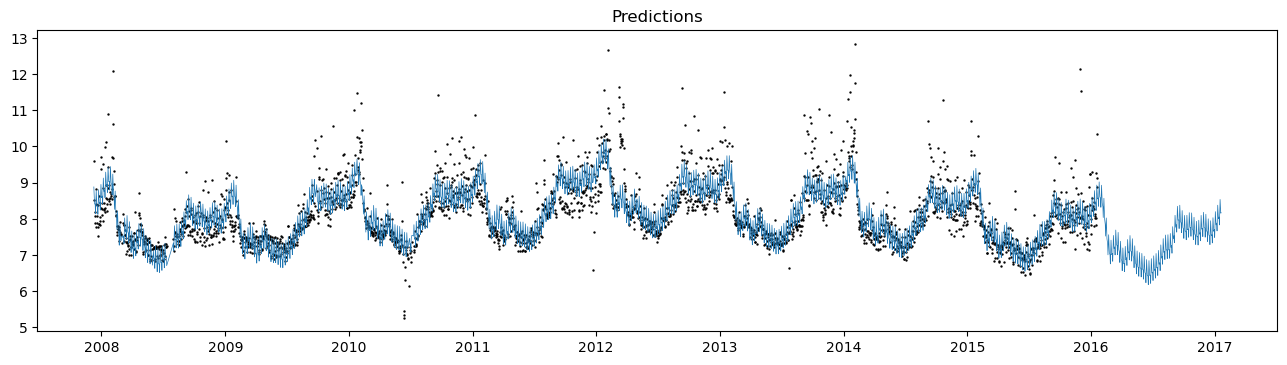

In [105]:
model = MyProphet()
model.fit(df)
preds = model._predict_map(365, plot=True)

In [7]:
with model.model:
    linear_seasonality_trace = pm.sample(2000, return_inferencedata=True, nuts_sampler="pymc")
    linear_seasonality_posterior = pm.sample_posterior_predictive(trace=linear_seasonality_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 1220 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [obs]


Output()

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'beta_yearly'}>,
        <Axes: title={'center': 'beta_yearly'}>],
       [<Axes: title={'center': 'beta_weekly'}>,
        <Axes: title={'center': 'beta_weekly'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'trend'}>,
        <Axes: title={'center': 'trend'}>]], dtype=object)

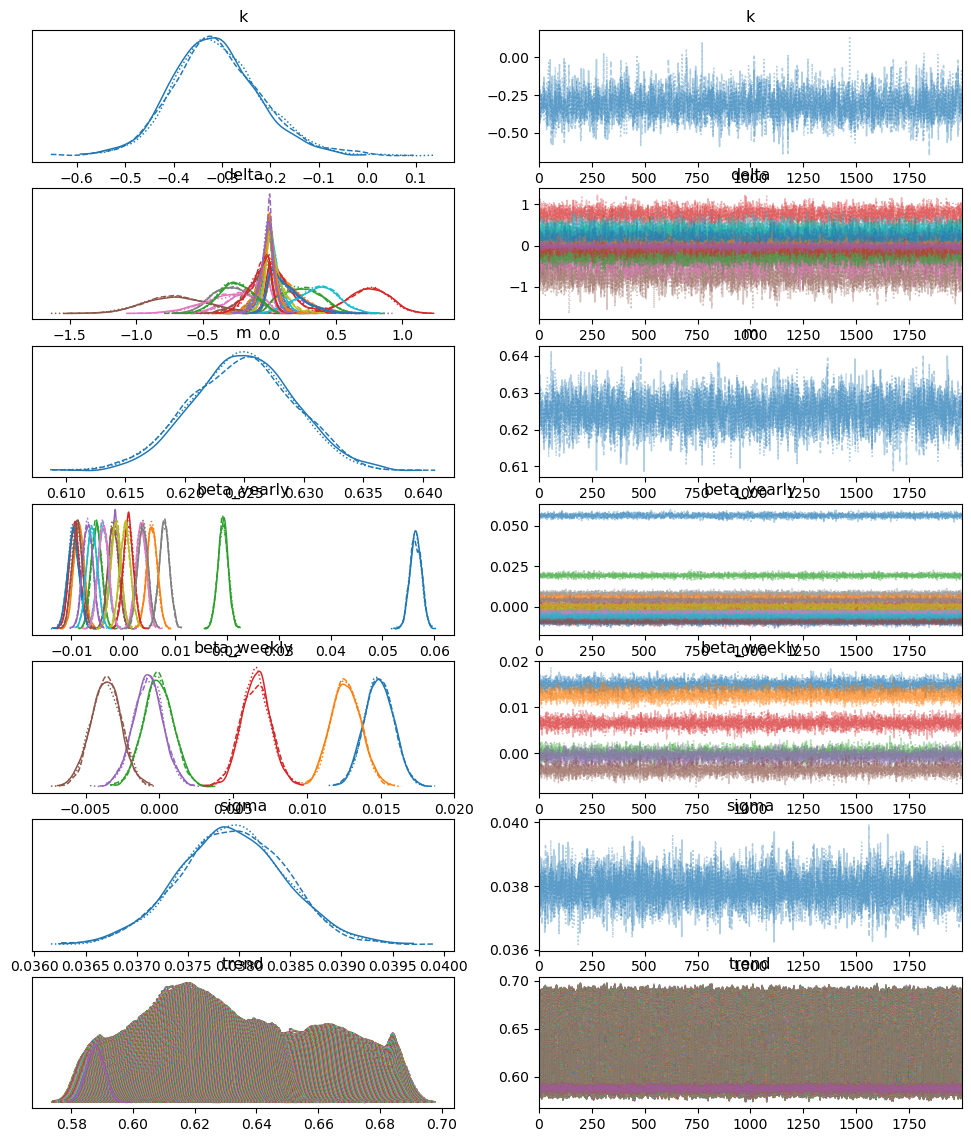

In [8]:
pm.plot_trace(linear_seasonality_trace)